## makemore:part 5

In [32]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [33]:
words = open('names.txt','r').read().splitlines()
words[:3]

['emma', 'olivia', 'ava']

In [34]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [35]:
#shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [52]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
      X, Y = [], []

      for w in words:
        context = [0] * block_size
        for ch in w + '.':
          ix = stoi[ch]
          X.append(context)
          Y.append(ix)
          context = context[1:] + [ix] # crop and append

      X = torch.tensor(X)
      Y = torch.tensor(Y)
      print(X.shape, Y.shape)
      return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [53]:
for x,y in zip(Xtr[:20],Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x),'--->',itos[y.item()])

........ ---> y
.......y ---> u
......yu ---> h
.....yuh ---> e
....yuhe ---> n
...yuhen ---> g
..yuheng ---> .
........ ---> d
.......d ---> i
......di ---> o
.....dio ---> n
....dion ---> d
...diond ---> r
..diondr ---> e
.diondre ---> .
........ ---> x
.......x ---> a
......xa ---> v
.....xav ---> i
....xavi ---> e


In [90]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      #change
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
#------------------------------------------------------------------------------------------------
class Embedding:# pytorch also has this
    def __init__(self,num_embeddings,embedding_dim):
        self.weight=torch.randn((num_embeddings,embedding_dim))
    def __call__(self,IX):
        self.out = self.weight[IX]
        return self.out
    def parameters(self):
        return [self.weight]
#------------------------------------------------------------------------------------------------
# class Flatten:
       
#     def __call__(self,x):
#         self.out=x.view(x.shape[0],-1)
#         return self.out
#     def parameters(self):
#         return []
# changing flatten
class FlattenConsecutive:
    def  __init__(self,n):# it flattens some n and pus them into the last dimension
        self.n=n
    def __call__(self,x):
        B,T,C = x.shape # in our below example B=4,t=8,C=10 4 is number of examples and 8 is the context and 10 is the features we are learning
        x = x.view(B,T//self.n,C*self.n)
        if x.shape[1]==1:
            x=x.squeeze(1) # it squeezes out all the dimensions that are 1
        self.out=x
        return self.out
    def parameters(self):
        return []
#------------------------------------------------------------------------------------------------
class Sequential:
    def __init__(self,layers):
        self.layers=layers
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        self.out=x
        return self.out
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [55]:
torch.manual_seed(42); # seed rng for reproducibility

In [119]:
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP # we changed it to 68 from 200 to make parameters same and we will see if this is better architecture 
C = torch.rand((vocab_size,n_embd))
# in nn there are containers which is a way of organizing layers using list or dict
model = Sequential([
    Embedding(vocab_size,n_embd),
    FlattenConsecutive(2), Linear(n_embd*2, n_hidden,bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden,bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden,bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),# last layer linear for output
])

# parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer make less confident

parameters =model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


### scratch space

In [95]:
ix= torch.randint(0,Xtr.shape[0],(4,))# let's look at a batch of just 4 examples
Xb, Yb = Xtr[ix],Ytr[ix]
logits = model(Xb)
print(Xb.shape)#[4x8] 8 characters for each examples
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0, 18, 15,  4, 15, 12,  6, 15],
        [ 3,  1, 12, 12,  1,  7,  8,  1],
        [ 0,  0,  0,  0,  0,  3, 15, 18]])

In [96]:
for layer in model.layers:# when block size we inputted not 2
    print(layer.__class__.__name__,":",tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [70]:
# first layer of our nn is the embedding layer 
model.layers[0].out.shape # output of the embedding layer
# we are trying to learn 10 features for each character so [4,8,10]

torch.Size([4, 8, 10])

In [71]:
model.layers[1].out.shape #output of the flatten layer
# views this tensor as 4,80 just the above thing viewed in a different  

torch.Size([4, 80])

In [72]:
model.layers[2].out.shape #output of linear layer

torch.Size([4, 200])

In [78]:
(torch.randn(4,80)@ torch.randn(80,200) + torch.randn(200)).shape# this is what happening in the linear layer
# the x need not be a 2 dimensional vector it can be more
(torch.randn(4,5,2,80)@ torch.randn(80,200) + torch.randn(200)).shape #torch.Size([4, 5, 2, 200])

torch.Size([4, 5, 2, 200])

In [ ]:
# effectively whats happening is matrix mulitplication is applied on last dimension and other are left unchanged
# we have these 8 characters coming in we dont want to flatten it out , we dont want to matrix multiply 80
# instead we want to group this
# (1 2) (3 4) (5 6) (7 8)
# every consecutive 2 elements shd be flattened out and multiply by weight matrices
# we can  matrix multiply these in parallel 

In [ ]:
# (torch.randn(4,80)@ torch.randn(80,200) + torch.randn(200)).shape we dont want this
(torch.randn(4,4,20)@ torch.randn(20,200) + torch.randn(200)).shape 
# we want this so we have to change the flatten layer so that it gives 4,4,20 instead of 4,80 
# and alsoo we want to change the linear layer so tht it expects 20 numbers

In [86]:
list(range(0,10,2))

[0, 2, 4, 6, 8]

In [82]:
# currently it is doing this
e = torch.randn(4,8,10)
e.view(4,-1).shape

torch.Size([4, 80])

In [83]:
# we want that to be consecutive 10-d vectors get concatenated
e = torch.randn(4,8,10)
e.view(4,-1,20).shape

torch.Size([4, 4, 20])

In [89]:
explicit=torch.cat([e[:,::2,:],e[:,1::2,:]],dim=2)
(explicit==e.view(4,-1,20)).all()

tensor(True)

In [113]:
for layer in model.layers:# when 2 is the input and we did the full optimization
    print(layer.__class__.__name__,":",tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


In [114]:
e = torch.randn(32,4,68)
emean = e.mean(0,keepdims=True)# 1,4,68 # what we are getting is mean over only the first dimension 
evar = e.var(0,keepdims=True)# 1,4,68
ehat = (e-emean)/torch.sqrt(evar+1e5)# 32,4,68
ehat.shape

torch.Size([32, 4, 68])

In [116]:
# pytorch mean and var can take tuple dim  also 
e = torch.randn(32,4,68)
emean = e.mean((0,1),keepdims=True)# 1,1,68  
evar = e.var((0,1),keepdims=True)# 1,1,68
ehat = (e-emean)/torch.sqrt(evar+1e5)# 32,4,68
ehat.shape

torch.Size([32, 4, 68])

In [117]:
emean.shape

torch.Size([1, 1, 68])

In [118]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 68])

### optimization

In [120]:
max_steps = 200000
batch_size = 32
lossi=[]


for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,))
    Xb,Yb = Xtr[ix],Ytr[ix]
    #forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits,Yb)#loss function
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    lr = 0.1 if i<150000 else 0.01 #learning rate decay
    for p in parameters:
        p.data += -lr*p.grad
    #track stats
    if i%10000==0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    

      0/ 200000:3.6050
  10000/ 200000:2.0735
  20000/ 200000:2.1947
  30000/ 200000:2.0963
  40000/ 200000:2.1665
  50000/ 200000:2.5522
  60000/ 200000:1.8361
  70000/ 200000:1.8633
  80000/ 200000:1.9130
  90000/ 200000:1.6443
 100000/ 200000:1.8622
 110000/ 200000:1.5901
 120000/ 200000:1.8301
 130000/ 200000:1.7545
 140000/ 200000:1.9715
 150000/ 200000:1.9720
 160000/ 200000:2.0220
 170000/ 200000:1.4837
 180000/ 200000:2.0199
 190000/ 200000:1.7412


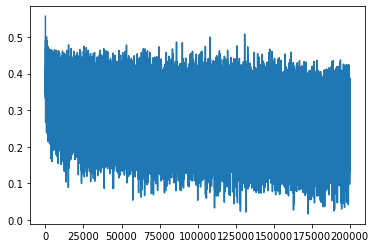

In [122]:
plt.plot(lossi)# because 32 batch elements are too few we can get lucky or unlucky thats why the graph comes thick initially we have to fix that shit

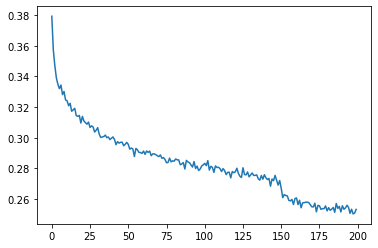

In [121]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))
# that dip is due to lr decay , it subtracted a ton of energy from out system and made it stable

In [123]:
for layer in model.layers:
    layer.training=False

In [124]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits,y)#loss function
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7713531255722046
val 1.9881757497787476


## Performance Log
* original (3 character context + 200 hidden neurons, 12K params): train 2.042 , val 2.106
* context 3 -> 8 (22K params): train 1.917, val 2.030 (just train the whole thing same just change the context length to 8 )
* flat -> hierarchical (22K params): train 1.941 , val 2.029(not a improvement yet) because batch norm is not working properly there is a bug in batch norm that it expects 2d input , it doesnt give error because everything broadcasts properly but batch norm is not doing what we want it to do
* fix batchnorm bug train 1.913, val 2.021
* scale up by increaseing the n_embd from 10 to 24 and n_hidden from 68 to 128 smtg , train 1.771 ,val 1.988

In [46]:
# when we pass context of single example to a batch norm that is in training mode we are going to end up calculating the variance of a single number which is nan
# torch.var(torch.tensor([5.0,4.0]))

tensor(0.5000)

In [125]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

arihav.
valen.
jazzley.
iovani.
tochenso.
kaola.
oylohnie.
rosalindo.
melandan.
quan.
tilah.
dillias.
diyus.
wilby.
taim.
edder.
armond.
keylon.
kanai.
lennna.
